In [1]:
import os
from pathlib import Path
import random

import numpy as np
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

## Скачивам датасеты

In [2]:
if not os.path.exists('CMP_facade_DB_base.zip'):
#     !wget http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip -O CMP_facade_DB_base.zip
    !curl http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip --output CMP_facade_DB_base.zip
    os.makedirs('data', exist_ok=True)
    os.makedirs('data/cmp_facade', exist_ok=True)
    !unzip -q CMP_facade_DB_base.zip -d data/cmp_facade
    
if not os.path.exists('CMP_facade_DB_extended.zip'):
#     !wget http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip -O CMP_facade_DB_base.zip
    !curl http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip --output CMP_facade_DB_extended.zip
    os.makedirs('data', exist_ok=True)
    os.makedirs('data/cmp_facade_extended', exist_ok=True)
    !unzip -q CMP_facade_DB_extended.zip -d data/cmp_facade_extended

## Объединяем датасеты

In [3]:
extended_path = Path('data/cmp_facade_extended/extended')
dataset_path = Path('data/cmp_facade/base')
for p in extended_path.iterdir():
    p.rename(dataset_path / p.name)

## Датасет

In [4]:
class Dataset:
    def __init__(self, datapath='data/cmp_facade/base', aligned=True, split='train', split_ratio=0.9):
        self.path = Path(datapath)
        self.split = split
        self.split_ratio = split_ratio
        self.aligned = aligned
        self.filenames = self.load()
        self.toTensor = transforms.ToTensor()
        self.test_resize = transforms.Resize((256, 256))
        self.train_resize = transforms.Resize((286, 286))
        
    def load(self):
        all_images = sorted([p for p in self.path.iterdir() if p.suffix=='.jpg'])
        all_masks = sorted([p for p in self.path.iterdir() if p.suffix=='.png'])
        if self.split == 'train':
            self.images = all_images[:int(self.split_ratio * len(all_images))]
            self.masks = all_masks[:int(self.split_ratio * len(all_masks))]
        elif self.split == 'test':
            self.images = all_images[int(self.split_ratio * len(all_images)):]
            self.masks = all_masks[int(self.split_ratio * len(all_masks)):]
        else:
            raise Exception('Wrong split!')
        if self.aligned:
            return
        random.shuffle(self.images)
        random.shuffle(self.masks)
            
    def transform(self, image, mask):
        image = self.train_resize(image)
        mask = self.train_resize(mask)
        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(256, 256))
        image = transforms.functional.crop(image, i, j, h, w)
        mask = transforms.functional.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        return image, mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx]).convert('RGB')
        
        if self.split == 'train':
            image, mask = self.transform(image, mask)
        elif self.split == 'test':
            image = self.test_resize(image)
            mask = self.test_resize(mask)
        image = self.toTensor(image)
        mask = self.toTensor(mask)
        
        return image, mask
        
    def __len__(self):
        return len(self.images)

In [5]:
dataset = Dataset(split='train')
len(dataset.masks)

545

In [6]:
image = dataset[0][0]
mask = dataset[0][1]

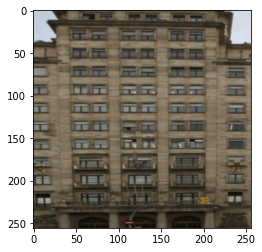

In [7]:
im = transforms.ToPILImage()(image).convert("RGB")
plt.imshow(im)
plt.show()

# Часть первая: перенос стиля при помощи pix2pix

## Модель на основе https://arxiv.org/pdf/1611.07004.pdf

In [8]:
def normal_init(conv, mean, std):
    conv.weight.data.normal_(mean, std)
    conv.bias.data.zero_()  

class DBlock(nn.Module):
    def __init__(self, in_channel, out_channel, batch_norm=True, mean=0.0, std=0.02):
        super(DBlock, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=(4, 4), stride=2, padding=1)
        normal_init(self.conv, mean, std)
        
        self.batch_norm = batch_norm
        if batch_norm:
#             self.bn = nn.BatchNorm2d(out_channel)
            self.bn = nn.InstanceNorm2d(out_channel)
    
    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        output = F.leaky_relu(x, 0.2)
        return output
    
class UBlock(nn.Module):
    def __init__(self, in_channel, out_channel, dropout=True, batch_norm=True, mean=0.0, std=0.02):
        super(UBlock, self).__init__()
        self.conv_t = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=(4, 4), stride=2, padding=1)
        normal_init(self.conv_t, mean, std)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
#             self.batch_norm_layer = nn.BatchNorm2d(out_channel)
            self.batch_norm_layer = nn.InstanceNorm2d(out_channel)
        self.dropout = dropout
        if self.dropout:
            self.dropout_layer = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv_t(x)
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        if self.dropout:
            x = self.dropout_layer(x)
        output = F.relu(x)
        return output
    
class UGenerator(nn.Module):
    def __init__(self, mean=0.0, std=0.02):
        super(UGenerator, self).__init__()
        self.dblocks = nn.ModuleList()
        batch_norm = [0, 1, 1, 1, 1, 1, 1, 0]
        dblocks_input = [3, 64, 128, 256, 512, 512, 512, 512]
        dblocks_output = dblocks_input[1:] + [512]
        for i in range(len(dblocks_input)): 
            self.dblocks.append(DBlock(dblocks_input[i], dblocks_output[i], batch_norm=batch_norm[i], mean=mean, std=std))
        
        self.ublocks = nn.ModuleList()
        ublocks_input = [512, 1024, 1536, 1536, 1536, 1280, 640, 320]
        ublocks_output = [512, 1024, 1024, 1024, 1024, 512, 256, 128]
        batch_norm = [1, 1, 1, 1, 1, 1, 1, 1]                      
        for i in range(len(ublocks_input)): 
            self.ublocks.append(UBlock(ublocks_input[i], ublocks_output[i], batch_norm=batch_norm[i], mean=mean, std=std))
            
        self.conv = nn.Conv2d(131, 3, kernel_size=(1, 1))
        normal_init(self.conv, mean, std)
        
    def forward(self, x):
        downsamples = [x]
        for block in self.dblocks:
            downsamples.append(block(downsamples[-1]))
        y = downsamples[-1]
        n = len(downsamples)
        for i, block in enumerate(self.ublocks):
            y = block(y)
            y = torch.cat([y, downsamples[n - 2 - i]], dim=1)
            
        output = torch.tanh(self.conv(y))
        return output
    
class PatchDescriminator(nn.Module):
    def __init__(self, mean=0.0, std=0.02):
        super(PatchDescriminator, self).__init__()
        self.dblocks = nn.ModuleList()
        dblocks_input = [6, 64, 128, 256]
        dblocks_output = dblocks_input[1:] + [512]
        for i in range(len(dblocks_input)): 
            self.dblocks.append(DBlock(dblocks_input[i], dblocks_output[i], batch_norm=(i!=0), mean=mean, std=std))
            
        self.conv = nn.Conv2d(512, 1, kernel_size=(16, 16))
        normal_init(self.conv, mean, std)
    
    def forward(self, x, masks):
        x = torch.cat([x, masks], 1)
        for block in self.dblocks:
            x = block(x)
        x = torch.sigmoid(self.conv(x))
        return x.view((x.shape[0], -1))

In [9]:
def plot_images(images, masks, fakes):
    pil_images = []
    pil_masks = []
    pil_fakes = []
    batch_size = images.shape[0]
    for idx in range(batch_size):
        pil_images.append(transforms.ToPILImage()(images[idx]).convert("RGB"))
        pil_masks.append(transforms.ToPILImage()(masks[idx]).convert("RGB"))
        pil_fakes.append(transforms.ToPILImage()(fakes[idx]).convert("RGB"))
    fig = plt.figure(figsize=(20, 30))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(3, batch_size),
                     axes_pad=0.5,
                     )
        
    images_to_show = pil_images + pil_masks + pil_fakes

    for ax, im in zip(grid, images_to_show):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

In [10]:
netG = UGenerator()
netD = PatchDescriminator()
netG.train()
netD.train()
x = torch.ones((2, 3, 256, 256))
mask = torch.ones((2, 3, 256, 256))
print(netG(mask).shape)
print(netD(x, mask).shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 1])


In [11]:
batch_size = 1
train_dataset = Dataset(split='train')
test_dataset = Dataset(split='test')
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

lr, beta1, beta2, l1_lambda = 0.0002, 0.5, 0.999, 100
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))

In [93]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
netG.to(device)
netD.to(device)
print(device)

cuda


In [94]:
num_epochs = 200

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    time.sleep(0.5)
    d_losses = []
    g_losses = []
    netG.train()
    netD.train()
    for batch in tqdm.tqdm(train_dataloader):
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        
        valid = Variable(torch.Tensor(images.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.Tensor(images.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        
        # Generator loss
        optimizer_G.zero_grad()
        generated = netG(masks)
        g_loss = F.binary_cross_entropy(netD(generated, masks), valid) + l1_lambda * F.l1_loss(generated, images)
        g_loss.backward()
        optimizer_G.step()

        # Dicriminator loss
        optimizer_D.zero_grad()
        # Функции потерь на настоящих и фейковых картинках
        real_loss = F.binary_cross_entropy(netD(images, masks), valid)
        fake_loss = F.binary_cross_entropy(netD(generated.detach(), masks), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    print(f'g_loss: {np.mean(g_losses)} d_loss: {np.mean(d_losses)}')
    if (epoch + 1) % 10 == 0:
        netG.eval()
        plot_images(images, masks, generated.detach())

Epoch 1


  2%|▏         | 12/545 [00:02<01:53,  4.68it/s]


KeyboardInterrupt: 

In [55]:
torch.save(netG.state_dict(), 'netG_pix2pix_batch_8.pth')
torch.save(netD.state_dict(), 'netD_pix2pix_batch_8.pth')

In [ ]:
netG.load_state_dict(torch.load('netG_pix2pix_batch_8.pth'))
netD.load_state_dict(torch.load('netD_pix2pix_batch_8.pth'))

In [57]:
test_dataloader = data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)
dataiter = iter(test_dataloader)
netG.eval()
print('ready!')

ready!


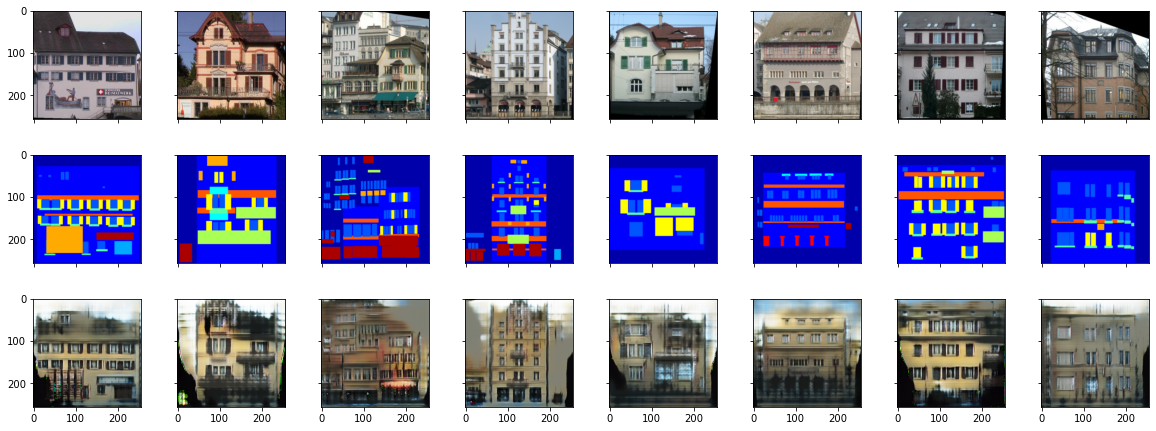

In [58]:
batch = next(dataiter)
images, masks = batch
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    generated = netG(masks)

plot_images(images, masks, generated)

В статье рекомендуют обучать с batch_size=1, но это занимает больше времени, поэтому попробовать не успел и перехожу к CycleGAN)

# Часть вторая: добавим циклы

Я имплементировал сети из статьи, но обучить их не получилось, лучший результат показал генератор из предыдущего задания на базе Unet. Тем не менее его тоже не получилось дообучить, ниже видно, что по сути получились 2 автоенкодера, а на самом деле дискриминаторы все время впадают в состояние, когда на все предсказывают 1 - побороть это пока не удалось.

In [10]:
class C7S1Block(nn.Module):
    def __init__(self, in_channel, out_channel, batch_norm=True, mean=0.0, std=0.02):
        super(C7S1Block, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=(7, 7), stride=1, padding=3)
        normal_init(self.conv, mean, std)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = nn.InstanceNorm2d(out_channel)
    
    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        output = F.relu(x)
        return output
    
class DKBlock(nn.Module):
    def __init__(self, in_channel, out_channel, batch_norm=True, mean=0.0, std=0.02):
        super(DKBlock, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), stride=2, padding=1)
        normal_init(self.conv, mean, std)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = nn.InstanceNorm2d(out_channel)
    
    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        output = F.relu(x)
        return output
    
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, batch_norm=True, mean=0.0, std=0.02):
        super(ResBlock, self).__init__()
        self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), stride=1, padding=1)
        normal_init(self.conv_1, mean, std)
        self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel_size=(3, 3), stride=1, padding=1)
        normal_init(self.conv_2, mean, std)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn_1 = nn.BatchNorm2d(out_channel)
            self.bn_2 = nn.BatchNorm2d(out_channel)
    
    def forward(self, x):
        output = self.conv_1(x)
        if self.batch_norm:
            output = self.bn_1(output)
        output = F.relu(output)
        output = self.conv_2(output)
        if self.batch_norm:
            output = self.bn_2(output)
        
        output = x + output
        output = F.relu(output)
        return output
    
class UKBlock(nn.Module):
    def __init__(self, in_channel, out_channel, dropout=True, batch_norm=True, mean=0.0, std=0.02):
        super(UKBlock, self).__init__()
        self.conv_t = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=(4, 4), stride=2, padding=1)
        normal_init(self.conv_t, mean, std)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
#             self.batch_norm_layer = nn.BatchNorm2d(out_channel)
            self.batch_norm_layer = nn.InstanceNorm2d(out_channel)
    
    def forward(self, x):
        x = self.conv_t(x)
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        output = F.relu(x)
        return output

In [11]:
class GeneratorNet(nn.Module):
    def __init__(self, mean=0.0, std=0.02):
        super(GeneratorNet, self).__init__()
        self.blocks = nn.ModuleList()
        self.blocks.append(C7S1Block(3, 64))
        self.blocks.append(DKBlock(64, 128))
        self.blocks.append(DKBlock(128, 256))
        for i in range(9):
            self.blocks.append(ResBlock(256, 256))
        self.blocks.append(UKBlock(256, 128))
        self.blocks.append(UKBlock(128, 64))
        self.blocks.append(C7S1Block(64, 3))
        
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
class PatchDescriminatorUnconditional(nn.Module):
    def __init__(self, mean=0.0, std=0.02):
        super(PatchDescriminatorUnconditional, self).__init__()
        self.dblocks = nn.ModuleList()
        dblocks_input = [3, 128, 128, 256]
        dblocks_output = dblocks_input[1:] + [512]
        for i in range(len(dblocks_input)): 
            self.dblocks.append(DBlock(dblocks_input[i], dblocks_output[i], batch_norm=(i!=0), mean=mean, std=std))
            
        self.conv = nn.Conv2d(512, 1, kernel_size=(16, 16))
        normal_init(self.conv, mean, std)
    
    def forward(self, x):
        for block in self.dblocks:
            x = block(x)
        x = torch.sigmoid(self.conv(x))
        return x.view((x.shape[0], -1))

In [12]:
x = torch.ones((2, 3, 256, 256))

In [13]:
net = GeneratorNet()
net(x).shape

torch.Size([2, 3, 256, 256])

## Создаем и обучаем модели

In [14]:
netG = UGenerator()
netDG = PatchDescriminatorUnconditional()
netF = UGenerator()
netDF = PatchDescriminatorUnconditional()
netG.train()
netF.train()
netDG.train()
netDF.train()
x = torch.ones((2, 3, 256, 256))
mask = torch.ones((2, 3, 256, 256))
print(netG(mask).shape)
print(netDG(x).shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 1])


In [15]:
batch_size = 2
train_dataset = Dataset(split='train', aligned=False)
test_dataset = Dataset(split='test', aligned=False)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

lr, beta1, beta2, l1_lambda = 0.0002, 0.5, 0.999, 10
optimizer_G = torch.optim.Adam(list(netG.parameters()) + list(netF.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(list(netDG.parameters()) + list(netDF.parameters()), lr=lr, betas=(beta1, beta2))

In [16]:
def plot_images_cycle(images, masks, fake_images, fake_masks, rec_images, rec_masks):
    pil_images = []
    pil_masks = []
    pil_fake_images = []
    pil_fake_masks = []
    pil_rec_images = []
    pil_rec_masks = []
    batch_size = images.shape[0]
    for idx in range(batch_size):
        pil_images.append(transforms.ToPILImage()(images[idx]).convert("RGB"))
        pil_masks.append(transforms.ToPILImage()(masks[idx]).convert("RGB"))
        pil_fake_images.append(transforms.ToPILImage()(fake_images[idx]).convert("RGB"))
        pil_fake_masks.append(transforms.ToPILImage()(fake_masks[idx]).convert("RGB"))
        pil_rec_images.append(transforms.ToPILImage()(rec_images[idx]).convert("RGB"))
        pil_rec_masks.append(transforms.ToPILImage()(rec_masks[idx]).convert("RGB"))
    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(batch_size, 6),
                     axes_pad=0.5,
                     )
    images_to_show = []
    for idx in range(batch_size):    
        images_to_show.append(pil_images[idx])
        images_to_show.append(pil_fake_masks[idx])
        images_to_show.append(pil_rec_images[idx])
        images_to_show.append(pil_masks[idx])
        images_to_show.append(pil_fake_images[idx])
        images_to_show.append(pil_rec_masks[idx])

    for ax, im in zip(grid, images_to_show):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
netG.to(device)
netF.to(device)
netDG.to(device)
netDF.to(device)
print(device)

cuda


Epoch 1


100%|██████████| 272/272 [04:24<00:00,  1.03it/s]


gG_loss: 20.9157 gF_loss: 23.3397 gG_l1_loss: 3.5403 gF_l1_loss 2.6362 g_loss: 50.4319
real_loss_G 1.8579 fake_loss_G 3.8145  real_loss_F 1.1475  fake_loss_F 0.6484 d_loss: 3.7342
Epoch 2


100%|██████████| 272/272 [04:17<00:00,  1.06it/s]


gG_loss: 11.0084 gF_loss: 22.7733 gG_l1_loss: 2.7666 gF_l1_loss 1.8395 g_loss: 38.3878
real_loss_G 1.5217 fake_loss_G 61.7826  real_loss_F 0.6358  fake_loss_F 44.8492 d_loss: 54.3947
Epoch 3


100%|██████████| 272/272 [04:16<00:00,  1.06it/s]


gG_loss: 28.5023 gF_loss: 9.0591 gG_l1_loss: 2.4857 gF_l1_loss 1.7323 g_loss: 41.7793
real_loss_G 2.7982 fake_loss_G 29.1128  real_loss_F 0.5006  fake_loss_F 75.2339 d_loss: 53.8228
Epoch 4


100%|██████████| 272/272 [04:16<00:00,  1.06it/s]


gG_loss: 47.9285 gF_loss: 7.7753 gG_l1_loss: 2.6580 gF_l1_loss 1.8061 g_loss: 60.1679
real_loss_G 2.0003 fake_loss_G 4.2233  real_loss_F 4.7851  fake_loss_F 87.3615 d_loss: 49.1851
Epoch 5


100%|██████████| 272/272 [04:17<00:00,  1.06it/s]


gG_loss: 60.6028 gF_loss: 0.0779 gG_l1_loss: 2.6752 gF_l1_loss 1.8004 g_loss: 65.1563
real_loss_G 0.7874 fake_loss_G 2.4578  real_loss_F 0.0881  fake_loss_F 99.6480 d_loss: 51.4906


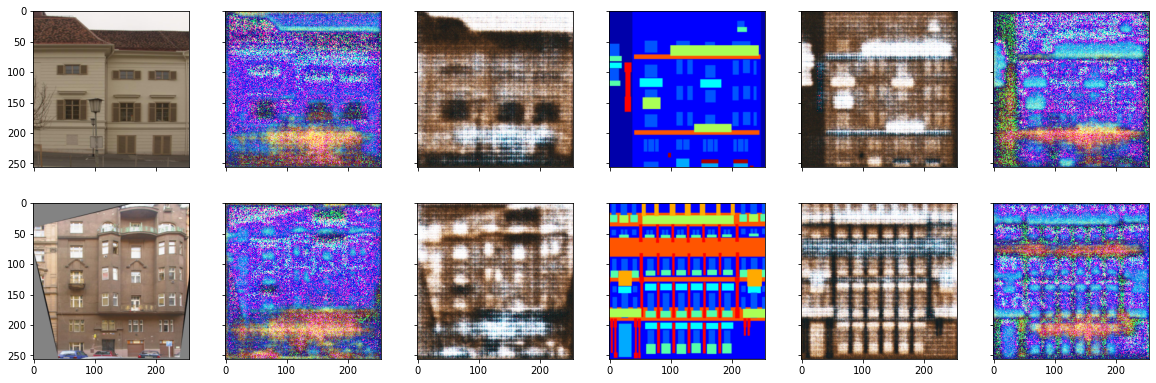

Epoch 6


100%|██████████| 272/272 [04:16<00:00,  1.06it/s]


gG_loss: 27.6034 gF_loss: 3.9159 gG_l1_loss: 2.5664 gF_l1_loss 1.6903 g_loss: 35.7759
real_loss_G 1.0020 fake_loss_G 54.9674  real_loss_F 0.7019  fake_loss_F 94.4174 d_loss: 75.5444
Epoch 7


100%|██████████| 272/272 [04:16<00:00,  1.06it/s]


gG_loss: 0.0038 gF_loss: 0.5397 gG_l1_loss: 1.9339 gF_l1_loss 1.3316 g_loss: 3.8090
real_loss_G 0.0000 fake_loss_G 100.0000  real_loss_F 0.0822  fake_loss_F 98.5962 d_loss: 99.3392
Epoch 8


100%|██████████| 272/272 [04:16<00:00,  1.06it/s]


gG_loss: 0.0000 gF_loss: 0.2189 gG_l1_loss: 1.6943 gF_l1_loss 1.2991 g_loss: 3.2122
real_loss_G 0.0000 fake_loss_G 100.0000  real_loss_F 0.0924  fake_loss_F 99.3127 d_loss: 99.7025
Epoch 9


100%|██████████| 272/272 [04:17<00:00,  1.06it/s]


gG_loss: 11.1125 gF_loss: 0.0000 gG_l1_loss: 1.7156 gF_l1_loss 1.3248 g_loss: 14.1529
real_loss_G 2.6372 fake_loss_G 82.4587  real_loss_F 0.0000  fake_loss_F 100.0000 d_loss: 92.5479
Epoch 10


100%|██████████| 272/272 [04:16<00:00,  1.06it/s]


gG_loss: 36.9972 gF_loss: 0.0000 gG_l1_loss: 1.4495 gF_l1_loss 1.2895 g_loss: 39.7362
real_loss_G 33.8239 fake_loss_G 59.1430  real_loss_F 0.0000  fake_loss_F 100.0000 d_loss: 96.4834


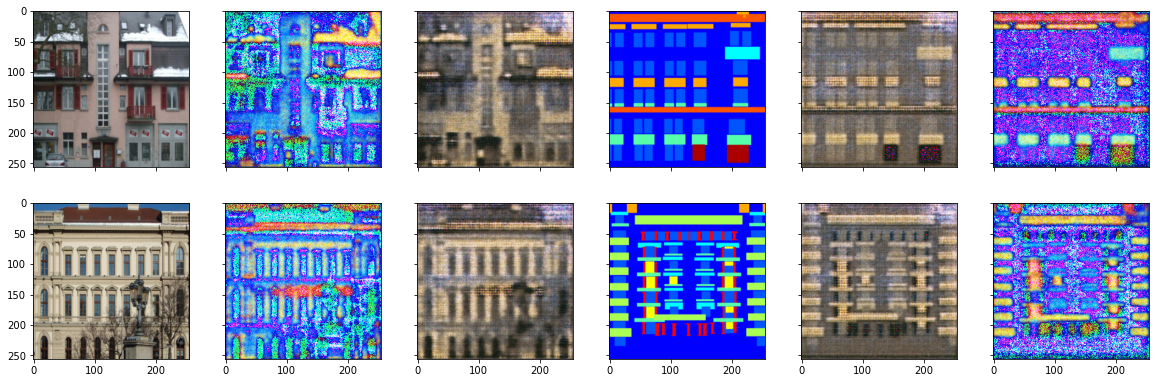

Epoch 11


100%|██████████| 272/272 [04:18<00:00,  1.05it/s]


gG_loss: 3.0994 gF_loss: 0.0000 gG_l1_loss: 1.5327 gF_l1_loss 1.4275 g_loss: 6.0596
real_loss_G 0.2590 fake_loss_G 94.1001  real_loss_F 0.0000  fake_loss_F 100.0000 d_loss: 97.1795
Epoch 12


100%|██████████| 272/272 [04:26<00:00,  1.02it/s]


gG_loss: 0.0000 gF_loss: 0.0000 gG_l1_loss: 1.1661 gF_l1_loss 1.1737 g_loss: 2.3398
real_loss_G 0.0000 fake_loss_G 100.0000  real_loss_F 0.0000  fake_loss_F 100.0000 d_loss: 100.0000
Epoch 13


100%|██████████| 272/272 [04:41<00:00,  1.03s/it]


gG_loss: 0.0000 gF_loss: 0.0000 gG_l1_loss: 1.0604 gF_l1_loss 1.0874 g_loss: 2.1478
real_loss_G 0.0000 fake_loss_G 100.0000  real_loss_F 0.0000  fake_loss_F 100.0000 d_loss: 100.0000
Epoch 14


100%|██████████| 272/272 [04:39<00:00,  1.03s/it]


gG_loss: 0.0000 gF_loss: 0.0000 gG_l1_loss: 0.9899 gF_l1_loss 1.0473 g_loss: 2.0372
real_loss_G 0.0000 fake_loss_G 100.0000  real_loss_F 0.0000  fake_loss_F 100.0000 d_loss: 100.0000
Epoch 15


100%|██████████| 272/272 [04:33<00:00,  1.00s/it]


gG_loss: 0.0000 gF_loss: 0.0000 gG_l1_loss: 0.9405 gF_l1_loss 1.0173 g_loss: 1.9577
real_loss_G 0.0000 fake_loss_G 100.0000  real_loss_F 0.0000  fake_loss_F 100.0000 d_loss: 100.0000


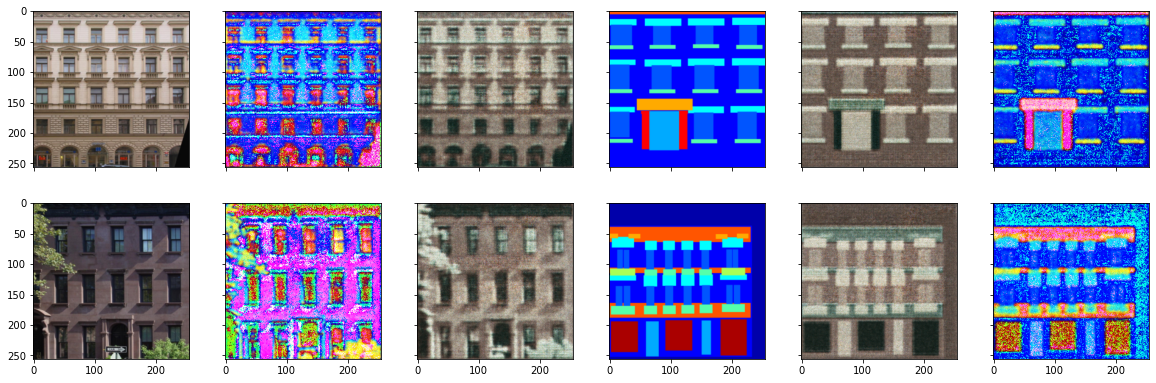

Epoch 16


  7%|▋         | 19/272 [00:19<04:14,  1.00s/it]


KeyboardInterrupt: 

In [18]:
start_epoch = 0
num_epochs = 100

for epoch in range(start_epoch, num_epochs):
    print(f'Epoch {epoch + 1}')
    time.sleep(0.5)
    d_losses = []
    g_losses = []
    gG_losses = []
    gF_losses = []
    gG_l1_losses = []
    gF_l1_losses = []
    real_losses_G = []
    real_losses_F = []
    fake_losses_G = []
    fake_losses_F = []
    netG.train()
    netF.train()
    netDG.train()
    netDF.train()
    for batch in tqdm.tqdm(train_dataloader):
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        
        valid = Variable(torch.Tensor(images.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.Tensor(images.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        
        # Generator loss
        optimizer_G.zero_grad()
        generated_images = netG(masks)
        cycle_masks = netF(generated_images)
        gG_loss = F.binary_cross_entropy(netDG(generated_images), valid)
        gG_l1_loss = l1_lambda * F.l1_loss(cycle_masks, masks)
#         gG_loss = torch.pow(netDG(generated_images) - valid, 2).mean() + l1_lambda * F.l1_loss(cycle_mask, masks)

        generated_masks = netF(images)
        cycle_images = netG(generated_masks)
        gF_loss = F.binary_cross_entropy(netDF(generated_masks), valid)
        gF_l1_loss = l1_lambda * F.l1_loss(cycle_images, images)
#         gF_loss = torch.pow(netDF(generated_masks) - valid, 2).mean() + l1_lambda * F.l1_loss(cycle_images, images)

        g_loss = gG_loss + gF_loss + gG_l1_loss + gF_l1_loss
        g_loss.backward()
        optimizer_G.step()

        # Dicriminator loss
        optimizer_D.zero_grad()
        generated_images = netG(masks)
        generated_masks = netF(images)
        # Функции потерь на настоящих и фейковых картинках
        real_loss_G = F.binary_cross_entropy(netDG(images), valid)
        real_loss_F = F.binary_cross_entropy(netDF(masks), valid)
#         real_loss = torch.pow(netDG(images) - valid, 2).mean() + torch.pow(netDF(masks) - valid, 2).mean()
        fake_loss_G = F.binary_cross_entropy(netDG(generated_images.detach()), fake)
        fake_loss_F = F.binary_cross_entropy(netDF(generated_masks.detach()), fake)
#         fake_loss = torch.pow(netDG(generated_images.detach()), 2).mean() + torch.pow(netDF(generated_masks.detach()), 2).mean()
        d_loss = (real_loss_G  + fake_loss_G) / 2 + (fake_loss_F + real_loss_F) / 2
        d_loss.backward()
        optimizer_D.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        gG_losses.append(gG_loss.item())
        gF_losses.append(gF_loss.item())
        gG_l1_losses.append(gG_l1_loss.item())
        gF_l1_losses.append(gF_l1_loss.item())
        real_losses_G.append(real_loss_G.item())
        real_losses_F.append(real_loss_F.item())
        fake_losses_G.append(fake_loss_G.item())
        fake_losses_F.append(fake_loss_F.item())
        
    print(f'gG_loss: {np.mean(gG_losses):0.4f} gF_loss: {np.mean(gF_losses):0.4f} gG_l1_loss: {np.mean(gG_l1_losses):0.4f} gF_l1_loss {np.mean(gF_l1_losses):0.4f} g_loss: {np.mean(g_losses):0.4f}')
    print(f'real_loss_G {np.mean(real_losses_G):0.4f} fake_loss_G {np.mean(fake_losses_G):0.4f}  real_loss_F {np.mean(real_losses_F):0.4f}  fake_loss_F {np.mean(fake_losses_F):0.4f} d_loss: {np.mean(d_losses):0.4f}')
    if (epoch + 1) % 5 == 0:
        plot_images_cycle(images, masks, generated_images.detach(), generated_masks.detach(), cycle_images.detach(), cycle_masks.detach())
    if (epoch + 1) % 10 == 0:
        torch.save(netG.state_dict(), f'netG_cycle_1{epoch+1}.pth')
        torch.save(netF.state_dict(), f'netF_cycle_1{epoch+1}.pth')
        torch.save(netDG.state_dict(), f'netDG_cycle_1{epoch+1}.pth')
        torch.save(netDF.state_dict(), f'netDF_cycle_1{epoch+1}.pth')